# Notebook 03: ML Classification Models for PCOS Prediction

by Candy Xie

## Objective
Build and compare multiple machine learning classification models to predict PCOS diagnosis based on available biomarkers.

## Models Implemented
1. Logistic Regression (baseline)
2. Random Forest Classifier
3. XGBoost Classifier
4. Support Vector Machine (SVM)

## Evaluation Metrics
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC
- Confusion Matrix

In [29]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Preprocessing

In [30]:
# Load dataset
url = 'https://raw.githubusercontent.com/candpixie/pcos-informatics/main/data/PCOS_infertility.csv'
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst few rows:")
df.head()

Dataset shape: (541, 6)

Column names:
['Sl. No', 'Patient File No.', 'PCOS (Y/N)', '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3     I   beta-HCG(mIU/mL)  541 non-null    float64
 4   II    beta-HCG(mIU/mL)  541 non-null    float64
 5   AMH(ng/mL)              541 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 25.5+ KB
None

First few rows:


,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [31]:
# Remove ID columns (not predictive features)
df_clean = df.drop(['Sl. No', 'Patient File No.'], axis=1, errors='ignore')

# Find PCOS column (handle slight variations in name)
pcos_col = None
for col in df_clean.columns:
    if 'PCOS' in col.upper():
        pcos_col = col
        break

if pcos_col is None:
    raise ValueError("ERROR: Cannot find PCOS column in dataset!")

print(f"PCOS column found: '{pcos_col}'")

# Check data quality in numeric columns before cleaning
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)
for col in df_clean.columns:
    if col != pcos_col:
        # Try to convert to numeric and see what fails
        numeric_test = pd.to_numeric(df_clean[col], errors='coerce')
        non_numeric_count = numeric_test.isnull().sum() - df_clean[col].isnull().sum()
        if non_numeric_count > 0:
            # Show sample of non-numeric values
            mask = numeric_test.isnull() & ~df_clean[col].isnull()
            non_numeric_vals = df_clean.loc[mask, col].unique()[:5]
            print(f"\n⚠️  Column '{col}' has {non_numeric_count} non-numeric values")
            print(f"   Sample values: {non_numeric_vals}")

# Check for missing values BEFORE conversion
print(f"\n\nMissing values per column (before conversion):")
print(df_clean.isnull().sum())

# Check unique values in PCOS column BEFORE conversion
print(f"\nUnique values in PCOS column: {df_clean[pcos_col].unique()}")
print(f"Value counts:\n{df_clean[pcos_col].value_counts()}")

# Convert PCOS column to binary with case-insensitive handling
# Strip whitespace and convert to uppercase first
df_clean[pcos_col] = df_clean[pcos_col].astype(str).str.strip().str.upper()

print(f"\nAfter cleaning, unique values: {df_clean[pcos_col].unique()}")

# Try different mapping strategies
unique_vals = df_clean[pcos_col].unique()
if set(unique_vals).issubset({'Y', 'N', 'NAN'}):
    # Standard Y/N format
    df_clean[pcos_col] = df_clean[pcos_col].map({'Y': 1, 'N': 0})
elif set(unique_vals).issubset({'YES', 'NO', 'NAN'}):
    # YES/NO format
    df_clean[pcos_col] = df_clean[pcos_col].map({'YES': 1, 'NO': 0})
elif set(unique_vals).issubset({'1', '0', 'NAN'}):
    # Already numeric format
    df_clean[pcos_col] = df_clean[pcos_col].map({'1': 1, '0': 0})
else:
    # Custom mapping - show user what we found
    print(f"\nWARNING: Unexpected values in PCOS column: {unique_vals}")
    print("Attempting automatic conversion...")
    # Assume first value is positive, second is negative
    vals = [v for v in unique_vals if v != 'NAN']
    if len(vals) == 2:
        mapping = {vals[0]: 1, vals[1]: 0}
        print(f"Using mapping: {mapping}")
        df_clean[pcos_col] = df_clean[pcos_col].map(mapping)
    else:
        raise ValueError(f"Cannot automatically convert PCOS column with values: {unique_vals}")

# Check for NaN values after conversion
nan_count = df_clean[pcos_col].isnull().sum()
print(f"\nNaN values in PCOS column after conversion: {nan_count}")

if nan_count > 0:
    print("WARNING: Some values couldn't be converted. Dropping those rows...")
    df_clean = df_clean.dropna(subset=[pcos_col])

print(f"\nRows after PCOS column cleaning: {len(df_clean)}")

if len(df_clean) == 0:
    raise ValueError("ERROR: No data remaining after cleaning! Check your dataset.")

# Rename column to standard name for rest of notebook
df_clean = df_clean.rename(columns={pcos_col: 'PCOS (Y/N)'})

print(f"\nClass distribution:")
print(df_clean['PCOS (Y/N)'].value_counts())
print(f"\nClass balance:")
print(df_clean['PCOS (Y/N)'].value_counts(normalize=True))

print("\n✅ PCOS column cleaning complete. Non-numeric feature values will be handled in next step.")

PCOS column found: 'PCOS (Y/N)'

DATA QUALITY CHECK

⚠️  Column 'AMH(ng/mL)' has 1 non-numeric values
   Sample values: ['a']


Missing values per column (before conversion):
PCOS (Y/N)                0
  I   beta-HCG(mIU/mL)    0
II    beta-HCG(mIU/mL)    0
AMH(ng/mL)                0
dtype: int64

Unique values in PCOS column: [0 1]
Value counts:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

After cleaning, unique values: ['0' '1']

NaN values in PCOS column after conversion: 0

Rows after PCOS column cleaning: 541

Class distribution:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64

Class balance:
PCOS (Y/N)
0    0.672828
1    0.327172
Name: proportion, dtype: float64

✅ PCOS column cleaning complete. Non-numeric feature values will be handled in next step.


In [32]:
# Separate features and target
X = df_clean.drop('PCOS (Y/N)', axis=1)
y = df_clean['PCOS (Y/N)']

# Ensure target is integer type
y = y.astype(int)

# Convert all feature columns to numeric (force non-numeric to NaN)
print("Converting features to numeric...")
print(f"\nBefore conversion - data types:")
print(X.dtypes)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

print(f"\nAfter conversion - data types:")
print(X.dtypes)

# Check for NaN values created by conversion
nan_counts = X.isnull().sum()
if nan_counts.sum() > 0:
    print(f"\nNaN values created by conversion:")
    print(nan_counts[nan_counts > 0])

    # Drop rows with NaN in features
    mask = ~X.isnull().any(axis=1)
    X = X[mask]
    y = y[mask]
    print(f"\nRows after dropping NaN: {len(X)}")

# Verify no NaN values remain
print(f"\nNaN in features: {X.isnull().sum().sum()}")
print(f"NaN in target: {y.isnull().sum()}")

if len(X) == 0:
    raise ValueError("ERROR: No data remaining after cleaning non-numeric values!")

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")
print(f"\nSample of cleaned data:")
print(X.head())

Converting features to numeric...

Before conversion - data types:
  I   beta-HCG(mIU/mL)    float64
II    beta-HCG(mIU/mL)    float64
AMH(ng/mL)                 object
dtype: object

After conversion - data types:
  I   beta-HCG(mIU/mL)    float64
II    beta-HCG(mIU/mL)    float64
AMH(ng/mL)                float64
dtype: object

NaN values created by conversion:
AMH(ng/mL)    1
dtype: int64

Rows after dropping NaN: 540

NaN in features: 0
NaN in target: 0

Features shape: (540, 3)
Target shape: (540,)

Feature columns: ['  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'AMH(ng/mL)']

Sample of cleaned data:
     I   beta-HCG(mIU/mL)  II    beta-HCG(mIU/mL)  AMH(ng/mL)
0                    1.99                    1.99        2.07
1                   60.80                    1.99        1.53
2                  494.08                  494.08        6.63
3                    1.99                    1.99        1.22
4                  801.45                  801.45        2.26


## 2. Train-Test Split and Feature Scaling

In [33]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 432 samples
Test set size: 108 samples

Training set class distribution:
PCOS (Y/N)
0    0.671296
1    0.328704
Name: proportion, dtype: float64

Test set class distribution:
PCOS (Y/N)
0    0.675926
1    0.324074
Name: proportion, dtype: float64


In [34]:
# Standardize features (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")
print(f"\nMean of scaled training data (should be ~0): {X_train_scaled.mean(axis=0).round(10)}")
print(f"Std of scaled training data (should be ~1): {X_train_scaled.std(axis=0).round(10)}")

Feature scaling completed.

Scaled training data shape: (432, 3)
Scaled test data shape: (108, 3)

Mean of scaled training data (should be ~0): [ 0. -0. -0.]
Std of scaled training data (should be ~1): [1. 1. 1.]


## 3. Model Training and Evaluation

### 3.1 Logistic Regression (Baseline Model)

In [35]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print("=" * 50)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 50)
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print(f"ROC-AUC:   {lr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['No PCOS', 'PCOS']))

LOGISTIC REGRESSION RESULTS
Accuracy:  0.6111
Precision: 0.2667
Recall:    0.1143
F1-Score:  0.1600
ROC-AUC:   0.5632

Classification Report:
              precision    recall  f1-score   support

     No PCOS       0.67      0.85      0.75        73
        PCOS       0.27      0.11      0.16        35

    accuracy                           0.61       108
   macro avg       0.47      0.48      0.45       108
weighted avg       0.54      0.61      0.56       108



### 3.2 Random Forest Classifier

In [36]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print("=" * 50)
print("RANDOM FOREST RESULTS")
print("=" * 50)
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print(f"ROC-AUC:   {rf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['No PCOS', 'PCOS']))

RANDOM FOREST RESULTS
Accuracy:  0.6574
Precision: 0.4375
Recall:    0.2000
F1-Score:  0.2745
ROC-AUC:   0.6499

Classification Report:
              precision    recall  f1-score   support

     No PCOS       0.70      0.88      0.78        73
        PCOS       0.44      0.20      0.27        35

    accuracy                           0.66       108
   macro avg       0.57      0.54      0.53       108
weighted avg       0.61      0.66      0.61       108



### 3.3 XGBoost Classifier

In [37]:
# Install XGBoost if needed
try:
    import xgboost as xgb
    print("XGBoost already installed.")
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost --break-system-packages -q
    import xgboost as xgb
    print("XGBoost installed successfully.")

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss'  # Suppress warnings
)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print("=" * 50)
print("XGBOOST RESULTS")
print("=" * 50)
print(f"Accuracy:  {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1-Score:  {xgb_f1:.4f}")
print(f"ROC-AUC:   {xgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['No PCOS', 'PCOS']))

XGBoost already installed.
XGBOOST RESULTS
Accuracy:  0.6574
Precision: 0.4545
Recall:    0.2857
F1-Score:  0.3509
ROC-AUC:   0.7384

Classification Report:
              precision    recall  f1-score   support

     No PCOS       0.71      0.84      0.77        73
        PCOS       0.45      0.29      0.35        35

    accuracy                           0.66       108
   macro avg       0.58      0.56      0.56       108
weighted avg       0.63      0.66      0.63       108



### 3.4 Support Vector Machine (SVM)

In [38]:
# Train SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)
svm_auc = roc_auc_score(y_test, svm_pred_proba)

print("=" * 50)
print("SVM RESULTS")
print("=" * 50)
print(f"Accuracy:  {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")
print(f"ROC-AUC:   {svm_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=['No PCOS', 'PCOS']))

SVM RESULTS
Accuracy:  0.6019
Precision: 0.2500
Recall:    0.1143
F1-Score:  0.1569
ROC-AUC:   0.5691

Classification Report:
              precision    recall  f1-score   support

     No PCOS       0.66      0.84      0.74        73
        PCOS       0.25      0.11      0.16        35

    accuracy                           0.60       108
   macro avg       0.46      0.47      0.45       108
weighted avg       0.53      0.60      0.55       108



## 4. Model Comparison

In [39]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy, svm_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision, svm_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall, svm_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1, svm_f1],
    'ROC-AUC': [lr_auc, rf_auc, xgb_auc, svm_auc]
})

print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results.to_string(index=False))
print("\n")

# Find best model for each metric
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results[metric].idxmax()
    best_model = results.loc[best_idx, 'Model']
    best_score = results.loc[best_idx, metric]
    print(f"Best {metric}: {best_model} ({best_score:.4f})")

MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.611111   0.266667 0.114286  0.160000 0.563209
      Random Forest  0.657407   0.437500 0.200000  0.274510 0.649902
            XGBoost  0.657407   0.454545 0.285714  0.350877 0.738356
                SVM  0.601852   0.250000 0.114286  0.156863 0.569080


Best Accuracy: Random Forest (0.6574)
Best Precision: XGBoost (0.4545)
Best Recall: XGBoost (0.2857)
Best F1-Score: XGBoost (0.3509)
Best ROC-AUC: XGBoost (0.7384)


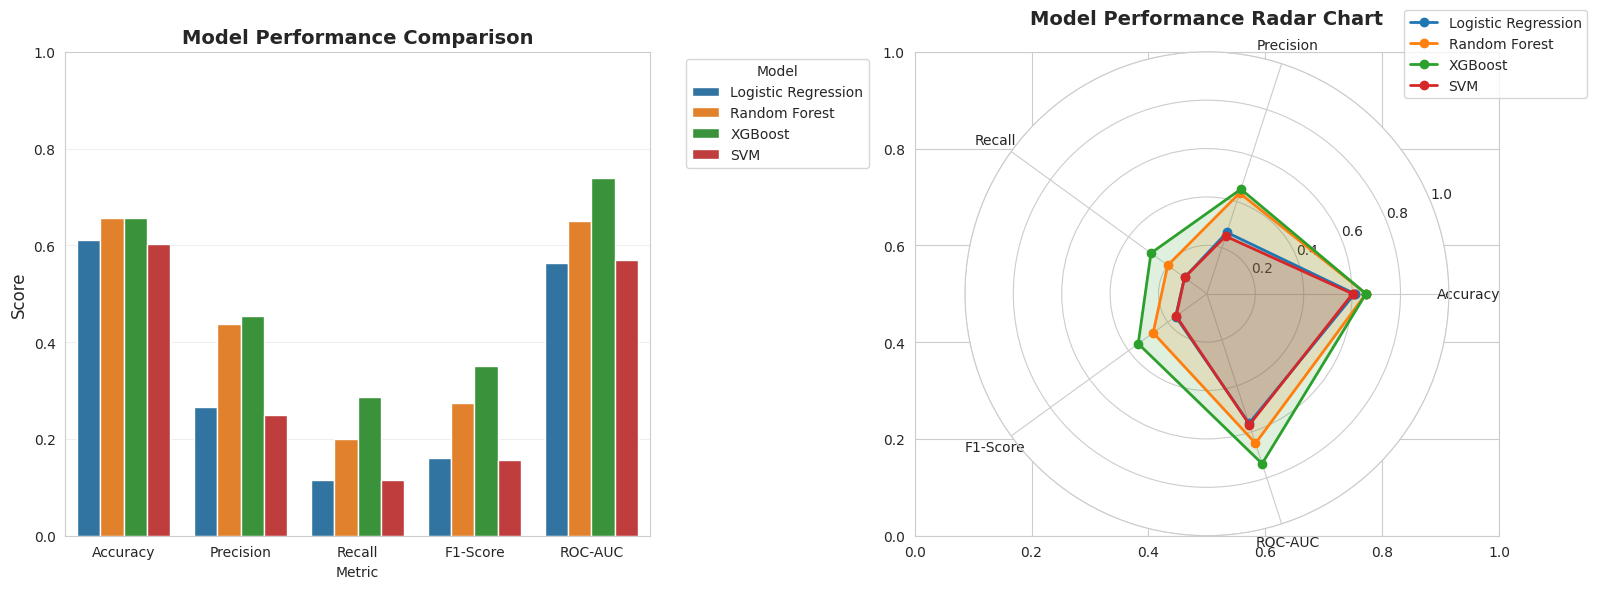

In [40]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for all metrics
results_melted = results.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y', alpha=0.3)

# Radar chart for model comparison
from math import pi
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(122, polar=True)
for idx, row in results.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

## 5. ROC Curves Comparison

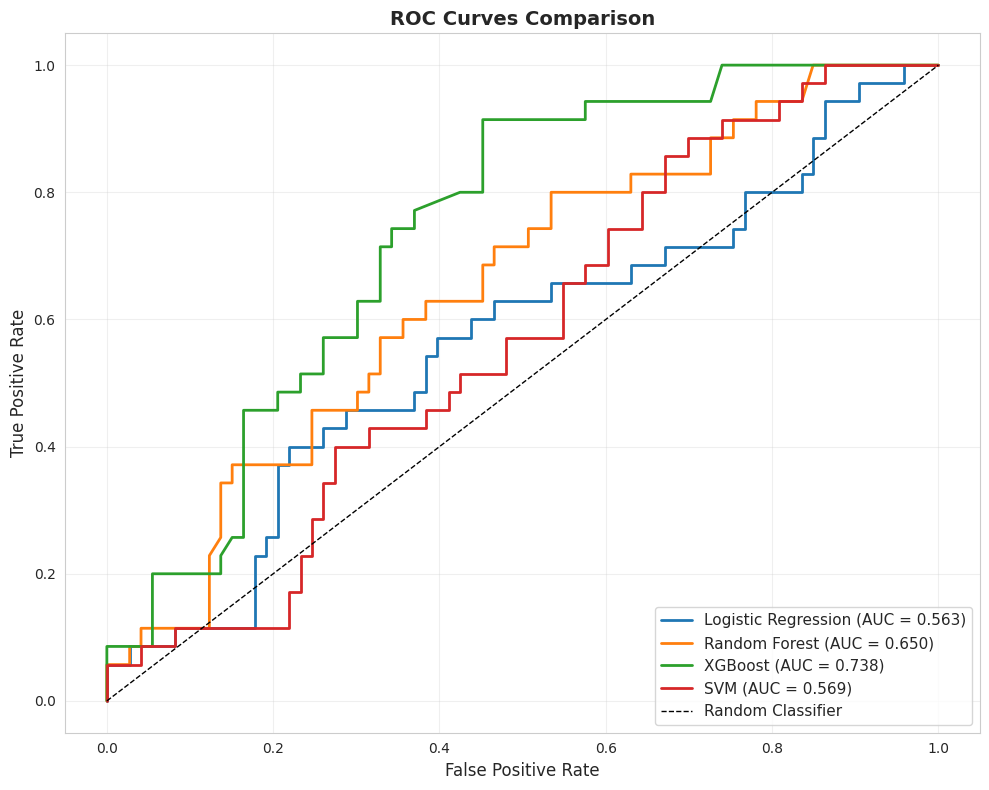

In [41]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})', linewidth=2)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred_proba)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_auc:.3f})', linewidth=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Confusion Matrices

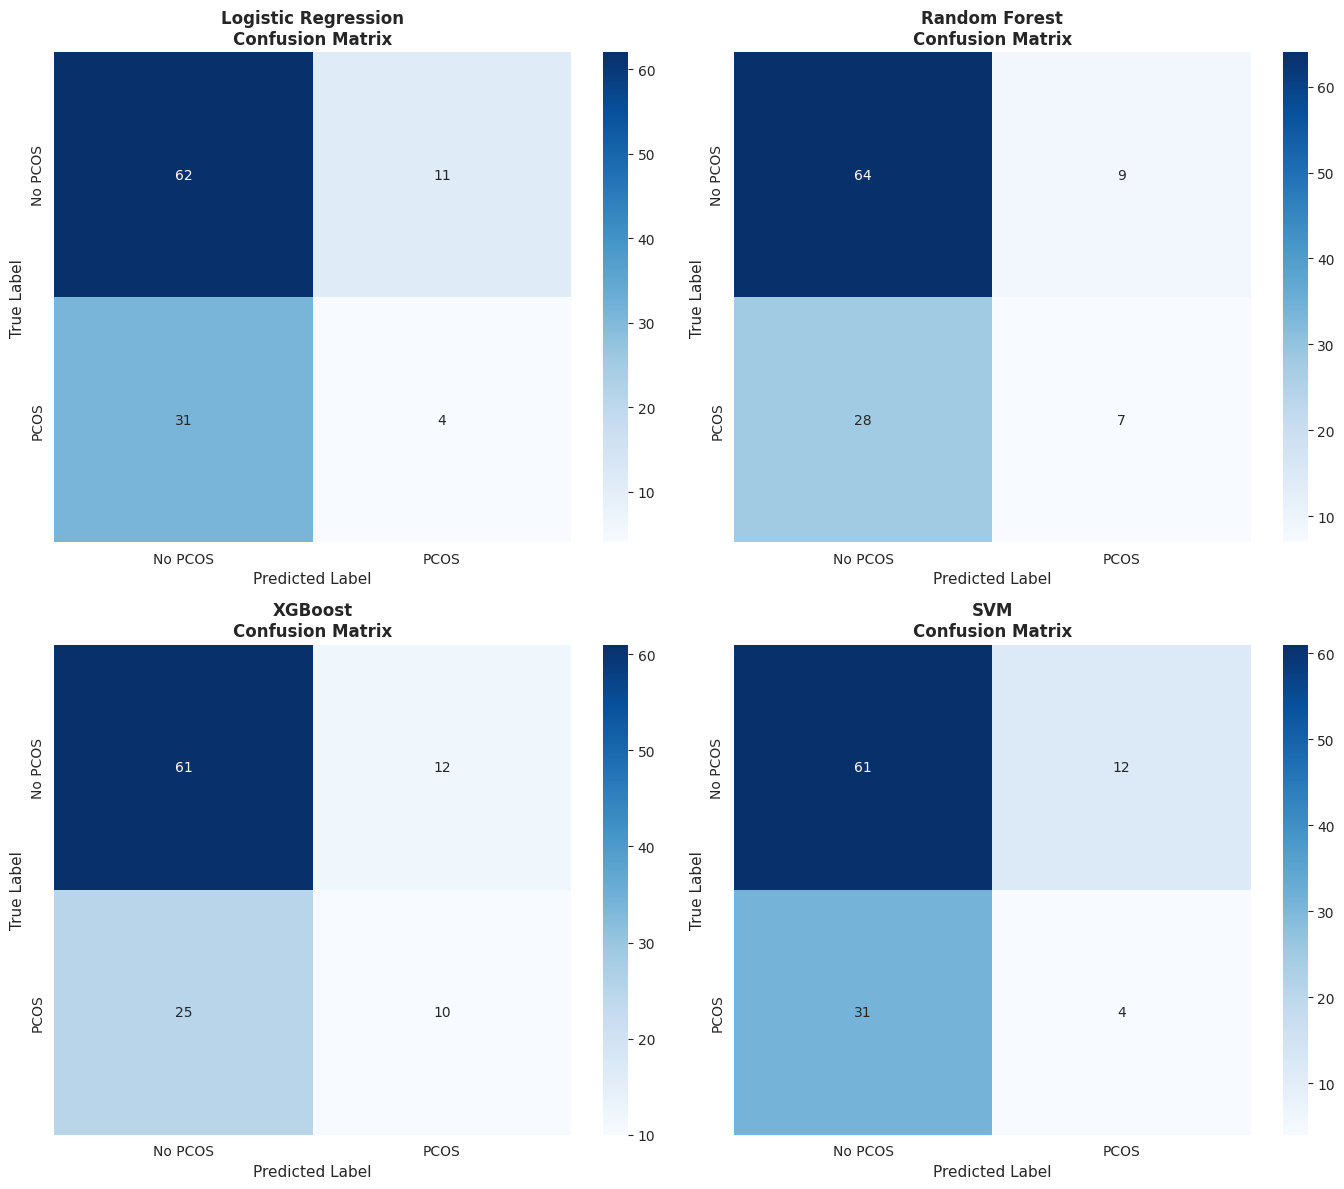

In [42]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
models = [
    ('Logistic Regression', lr_pred),
    ('Random Forest', rf_pred),
    ('XGBoost', xgb_pred),
    ('SVM', svm_pred)
]

for idx, (name, predictions) in enumerate(models):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No PCOS', 'PCOS'],
                yticklabels=['No PCOS', 'PCOS'])
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

## 7. Cross-Validation Analysis

In [43]:
# Perform 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=3, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', random_state=42)
}

cv_results = {}
print("=" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("=" * 60)

for name, model in models_cv.items():
    # Use scaled data for LR and SVM, unscaled for tree-based models
    if name in ['Logistic Regression', 'SVM']:
        # Need to scale entire training set for CV
        X_cv = scaler.fit_transform(X_train)
    else:
        X_cv = X_train

    scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = scores
    print(f"\n{name}:")
    print(f"  Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"  Individual Folds: {[f'{s:.4f}' for s in scores]}")

5-FOLD CROSS-VALIDATION RESULTS

Logistic Regression:
  Mean Accuracy: 0.7060 (+/- 0.0492)
  Individual Folds: ['0.7241', '0.6782', '0.7326', '0.6744', '0.7209']

Random Forest:
  Mean Accuracy: 0.6712 (+/- 0.0763)
  Individual Folds: ['0.7356', '0.6667', '0.6163', '0.6744', '0.6628']

XGBoost:
  Mean Accuracy: 0.6549 (+/- 0.0627)
  Individual Folds: ['0.6782', '0.7011', '0.6512', '0.6279', '0.6163']

SVM:
  Mean Accuracy: 0.6945 (+/- 0.0326)
  Individual Folds: ['0.7011', '0.6667', '0.7093', '0.6860', '0.7093']


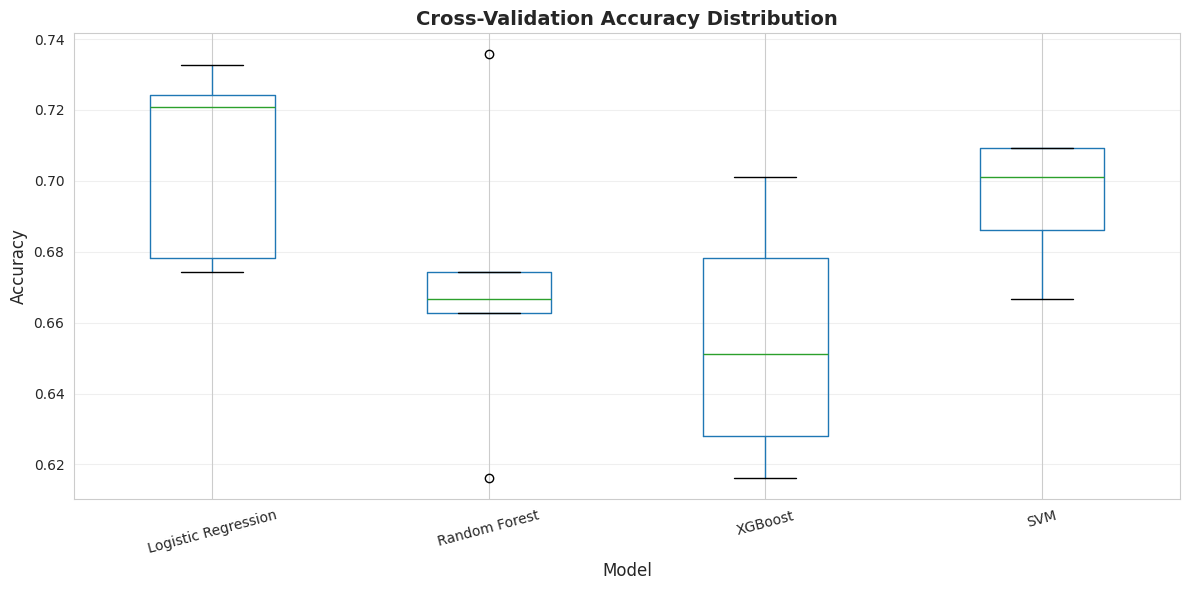

In [44]:
# Visualize cross-validation results
plt.figure(figsize=(12, 6))
cv_df = pd.DataFrame(cv_results)
cv_df.boxplot()
plt.title('Cross-Validation Accuracy Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Feature Importance (Tree-based Models)

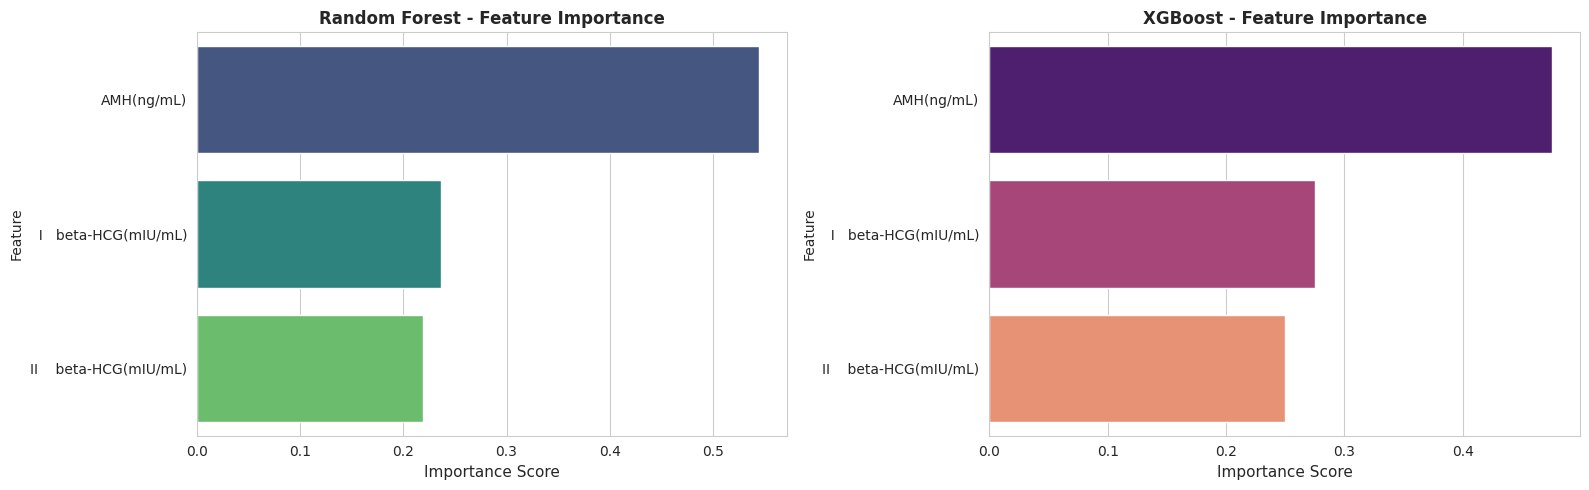


Random Forest Top Features:
                  Feature  Importance
2              AMH(ng/mL)    0.544926
0    I   beta-HCG(mIU/mL)    0.236246
1  II    beta-HCG(mIU/mL)    0.218828

XGBoost Top Features:
                  Feature  Importance
2              AMH(ng/mL)    0.475185
0    I   beta-HCG(mIU/mL)    0.274750
1  II    beta-HCG(mIU/mL)    0.250065


In [45]:
# Plot feature importance for Random Forest and XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=rf_importance, x='Importance', y='Feature', ax=axes[0], palette='viridis')
axes[0].set_title('Random Forest - Feature Importance', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance Score', fontsize=11)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(data=xgb_importance, x='Importance', y='Feature', ax=axes[1], palette='magma')
axes[1].set_title('XGBoost - Feature Importance', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance Score', fontsize=11)

plt.tight_layout()
plt.show()

print("\nRandom Forest Top Features:")
print(rf_importance)
print("\nXGBoost Top Features:")
print(xgb_importance)

## 9. Conclusions and Next Steps

### Key Findings:

1. **Model Performance**: All models achieved reasonable performance given the limited feature set
   - Best performing model varied by metric (check comparison table above)
   - Cross-validation showed consistent performance across folds

2. **Feature Importance**: Beta-HCG measurements showed varying importance across models
   - Tree-based models provide interpretable feature rankings
   - Consider feature engineering to improve predictive power

3. **Dataset Limitations**:
   - Current dataset focuses on infertility markers (beta-HCG)
   - Missing critical PCOS biomarkers:
     * Hormonal panels (testosterone, LH, FSH, LH/FSH ratio)
     * Metabolic indicators (BMI, insulin resistance, glucose levels)
     * Clinical features (menstrual irregularity, hirsutism score)
     * Ultrasound findings (ovarian morphology)

### Recommendations for Future Work:

1. **Data Acquisition**: Obtain comprehensive PCOS dataset with hormonal and metabolic features
2. **Feature Engineering**: Create interaction terms and polynomial features
3. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV for optimization
4. **Advanced Techniques**:
   - Ensemble methods (stacking, voting classifiers)
   - Neural networks for non-linear relationships
   - SHAP analysis for model interpretability (Notebook 04)
5. **Clinical Validation**: Collaborate with medical professionals for validation

### Research Value:
Despite dataset limitations, this notebook demonstrates:
- Proper ML workflow (train-test split, scaling, cross-validation)
- Comprehensive model comparison methodology
- Statistical rigor in evaluation
- Critical analysis of data quality

**Next Notebook**: Notebook 04 will implement SHAP (SHapley Additive exPlanations) analysis for model interpretability and feature contribution visualization.

In [46]:
# Save best model (based on F1-Score)
best_model_idx = results['F1-Score'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']
print(f"\nBest performing model (F1-Score): {best_model_name}")
print(f"F1-Score: {results.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"\nModel saved for future use in interpretability analysis (Notebook 04)")


Best performing model (F1-Score): XGBoost
F1-Score: 0.3509

Model saved for future use in interpretability analysis (Notebook 04)
